# Figure 3: Including CT feedback and behavior into the model significantly improves performance.

In [83]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, randomized_svd
import statsmodels
from statsmodels.stats.multitest import multipletests
from statannotations.Annotator import Annotator

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
def get_color_dict(palette_name='colorblind', n=None, color_names=None,
                   add_default_colors=True):
    """
    Returns color map dictionary from seaborn color palettes with hexadecimal triplet values.

    Parameters
    ----------
    palette_name : str
        Name of palette. Possible values are:
        'colorblind', 'deep', 'muted', 'bright', 'pastel', 'dark'
        For more options see seaborn.color_palette() docs.
    n : int
        Number of colors.
        If not None and arg color_names is given, arg n must be equal to len(color_names).
    color_names : list
        List of color names as strings e.g. for the color palette 'colorblind': ['blue',
        'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'yellow', 'lightblue']
        Must have the same length as colors in the color palette.
        If None, color names are set to ['c0', 'c1', 'c2', ...].
    add_default_colors : bool
        Add default colors that are need but that are not part of the color palette such as
        e.g. 'black'.
        If set to False, the color dict will only contain colors of the chosen palette.

    Returns
    -------
    color_dict: dict
         Color name as key and color triplet as value.
    """
    # Import done here to avoid problems for other user who don't have seaborn installed
    import seaborn as sns

    # Get list of sns colors as hexadecimal triplet
    sns_colors_l = sns.color_palette(palette_name).as_hex()
    if n is not None:
        sns_colors_l = sns_colors_l[:n]
    # Define color names if none are given
    if color_names is None:
        color_names = ["c%d" % i for i in range(0, len(sns_colors_l))]
    # Create color dict
    color_dict = dict.fromkeys(color_names)
    for color_name, color in zip(color_names, sns_colors_l):
        color_dict[color_name] = color
    # Add additional colors to palette
    if add_default_colors is True:
        color_dict['black'] = '#000000'

    return color_dict

In [3]:
color_dict = get_color_dict(color_names=['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'yellow', 'lightblue'])

# Load data

In [4]:
filename = './data/performance_data_.h5'
data = pd.read_hdf(filename, "df")
signif_level = 0.001

In [5]:
data.columns

Index(['config_name', 'config_color', 'config_stim', 'config_opto',
       'config_run', 'config_eye', 'm', 's', 'e', 'u', 'paramset', 'omi_e',
       'omi', 'omi_spont', 'rmi', 'emi', 'r_train', 'r_test', 'r_mean_train',
       'r_mean_test', 'perm_score_true', 'perm_score_stim', 'perm_score_opto',
       'perm_score_run', 'perm_score_eye', 'perm_score_true_mean',
       'perm_score_stim_mean', 'perm_score_opto_mean', 'perm_score_run_mean',
       'perm_score_eye_mean', 'perm_pvalue_stim', 'perm_pvalue_opto',
       'perm_pvalue_run', 'perm_pvalue_eye'],
      dtype='object')

In [6]:
no_stim_full = data[data['config_name']=='noStim_Full model']['r_test'].values
with_stim_full = data[data['config_name']=='Full model']['r_test'].values

In [84]:
#filename = './data/population_data.h5'
#data_population = pd.read_hdf(filename, "df")

filename = './data/population_data_movie_June24.csv'
data_population = pd.read_csv(filename)  

In [85]:
data_population.columns

Index(['Unnamed: 0', 'm', 's', 'e', 'u', 'paramset', 'fr_mean_e',
       'fr_mean_stim', 'fr_mean_spont_ctrl', 'fr_opto', 'fr_ctrl', 'fr_run',
       'fr_sit', 'fr_pupil_large', 'fr_pupil_small', 'reliability', 'omi',
       'rmi', 'emi', 'response_train', 'response_tv', 'opto_train',
       'run_train', 'eye_train', 'strf', 'srf', 'trf', 'srf_val', 'filt_opto',
       'filt_run', 'filt_eye', 'b', 'opto_triggered_data',
       'opto_triggered_yhat', 'data_omis', 'yhat_omis', 'data_omis_mean',
       'yhat_omis_mean', 'opto_triggered_data_100ms',
       'opto_triggered_yhat_100ms', 'data_omis_100ms', 'yhat_omis_100ms',
       'data_omis_mean_100ms', 'yhat_omis_mean_100ms', 'perm_score_true',
       'perm_score_stim', 'perm_score_opto', 'perm_score_run',
       'perm_score_eye', 'perm_score_true_mean', 'perm_score_stim_mean',
       'perm_score_opto_mean', 'perm_score_run_mean', 'perm_score_eye_mean',
       'perm_pvalue_stim', 'perm_pvalue_opto', 'perm_pvalue_run',
       'perm_pvalue_e

In [86]:
data_population

,Unnamed: 0,m,s,e,u,paramset,fr_mean_e,fr_mean_stim,fr_mean_spont_ctrl,fr_opto,...,perm_score_eye,perm_score_true_mean,perm_score_stim_mean,perm_score_opto_mean,perm_score_run_mean,perm_score_eye_mean,perm_pvalue_stim,perm_pvalue_opto,perm_pvalue_run,perm_pvalue_eye
0,0,Ntsr1Cre_2019_0007,6,9,7,10424,5.15567,5.15078,6.393940,4.82637,...,[ 0.10238294 0.08639394 -0.03121408 -0.004341...,0.265231,0.216329,0.258973,0.264138,0.074498,0.243693,0.598575,0.875993,5.749173e-07
1,1,Ntsr1Cre_2019_0007,6,9,8,10384,10.66550,10.73240,11.083300,10.29810,...,[0.523251 0.49585809 0.50441182 0.48402857 0...,0.553907,0.064897,0.553818,0.549458,0.540700,0.002308,0.943466,0.809348,2.322143e-01
2,2,Ntsr1Cre_2019_0007,6,9,9,10448,4.00446,4.00573,3.492420,4.29566,...,[ 0.42203534 0.39069923 0.34350381 0.364752...,0.378565,0.382064,0.372853,0.219037,0.270590,0.951074,0.743960,0.045773,7.102069e-02
3,3,Ntsr1Cre_2019_0007,6,9,10,10464,1.57930,1.58255,0.340909,1.56839,...,[0.07199185 0.19560769 0.20942372 0.1350314 0...,0.198688,0.137248,0.200548,0.128059,0.138032,0.183707,0.831443,0.066206,1.057014e-01
4,4,Ntsr1Cre_2019_0007,6,9,11,10384,8.83379,8.83711,10.295500,9.34275,...,[0.40782536 0.42384531 0.39250164 0.36872724 0...,0.416878,0.101603,0.414135,0.408540,0.354035,0.002308,0.701276,0.540222,1.491853e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,117,Ntsr1Cre_2020_0004,6,10,48,10392,10.01290,9.97340,10.356100,11.22370,...,[0.18584381 0.17791756 0.17736146 0.19200433 0...,0.278513,0.006003,0.273780,0.277571,0.265530,0.000373,0.680251,0.898415,6.186019e-01
118,118,Ntsr1Cre_2020_0004,6,10,51,10440,9.21080,9.20873,7.469700,9.25965,...,[-0.06426175 -0.05470522 -0.09848008 -0.002346...,0.070808,0.063438,0.067610,0.073865,-0.001919,0.837941,0.765591,0.831443,8.144624e-02
119,119,Ntsr1Cre_2020_0004,6,10,52,10424,14.18190,14.22590,7.613640,14.41590,...,[0.34725903 0.33456987 0.32113898 0.31615119 0...,0.344175,0.068527,0.331162,0.344277,0.299784,0.000373,0.432246,0.920910,3.329404e-02
120,120,Ntsr1Cre_2020_0004,6,10,56,10384,54.33970,54.53650,31.310600,54.54010,...,[0.12547042 0.09611975 0.20055801 0.21960464 0...,0.204190,0.058542,0.192897,0.201553,0.172544,0.000373,0.502875,0.787390,3.521558e-01


# Fetch info from DFs

In [96]:
data_set = 'test'

# Performance comparison all configs
sort_values = True
config_colors = ['#949494', '#0173b2', '#029e73', '#de8f05', '#56b4e9', '#fbafe4', '#d55e00', 'k']
config_names = ['Stimulus only', 'Stim.+Opto', 'Stim.+Run', 'Stim.+Eye', 'Stim.+Opto+Run', 'Stim.+Opto+Eye', 'Stim.+Run+Eye', 'Full model']
if sort_values==True:
    config_r_means = []
    for i in range(len(config_names)):
        config_r_means.append(np.mean(data[data['config_name'] == config_names[i]]['r_{:s}'.format(data_set)].values))
    idxs_sorted_idxs = np.array(config_r_means).argsort()
else:
    idxs_sorted_idxs = np.arange(config_names.shape[0])
# Create input config matrix for plotting
input_config = []
for config_name in config_names:
    input_config.append((data[data['config_name']==config_name].iloc[0][['config_stim', 'config_opto', 'config_run', 'config_eye']].values).astype(np.int))
input_config = np.vstack(input_config)
input_config = input_config[np.flip(idxs_sorted_idxs)[::-1]]    
        
# 'Stimulus only' vs. 'Full model' scatter colored by MIs
r_test_stim_only = data[data['config_name']=='Stimulus only']['r_{:s}'.format(data_set)].values
r_test_full_model = data[data['config_name']=='Full model']['r_{:s}'.format(data_set)].values
omis = data[data['config_name']=='Stimulus only']['omi'].values
rmis = data[data['config_name']=='Stimulus only']['rmi'].values
emis = data[data['config_name']=='Stimulus only']['emi'].values
mis = 1-(1-abs(omis))*(1-abs(rmis))*(1-abs(emis))
mi_names = ['omi', 'rmi', 'emi', 'mi']
mi_vals = [omis, rmis, emis, mis]
mi_labels = ['MI$_{CT~FB~supp.}$', 'MI$_{Run}$', 'MI$_{Pupil}$', 'MI$_{Joint}$']

### Significance test

In [88]:
pvals = []
r_stim_only = data[data['config_name']=='Stimulus only']['r_test'].values
for config_name in config_names[1:]:
    r_compare = data[data['config_name']==config_name]['r_test'].values
    #stats, pval = scipy.stats.mannwhitneyu(r_stim_only, r_compare, alternative='two-sided')
    stats, pval = scipy.stats.wilcoxon(r_stim_only, r_compare, alternative='two-sided')
    pvals.append(pval)
pvals = np.array(pvals)
reject, pvals_corrected, alphacSidak, alphacBonf = statsmodels.stats.multitest.multipletests(pvals, alpha=0.05, method='bonferroni')

for i, config_name in enumerate(config_names[1:]):
    print(config_name)
    print('\t'+str(pvals_corrected[i]))

# Format p-values for plotting
formatted_pvalues = []
for p in pvals_corrected:
    if 1.00e-02 < p <= 5.00e-02:
        formatted_pvalues.append('*')
    elif 1.00e-03 < p <= 1.00e-02:
        formatted_pvalues.append('**')
    elif 1.00e-04 < p <= 1.00e-03:
        formatted_pvalues.append('***')
    elif p <= 1.00e-04:
        formatted_pvalues.append('****')
    else:
        formatted_pvalues.append('ns') 
# Select pairs
pairs=[('Stimulus only', 'Stim.+Opto'),
       ('Stimulus only', 'Stim.+Eye'),
       ('Stimulus only', 'Full model'),
      ]
formatted_pvalues_plot = []
for pair in pairs:
    position = config_names[1:].index(pair[1])
    formatted_pvalues_plot.append(np.array(formatted_pvalues)[position])

Stim.+Opto
	0.546876352277542
Stim.+Run
	0.0907540586833929
Stim.+Eye
	3.3966034701451153e-06
Stim.+Opto+Run
	0.0001046425047642577
Stim.+Opto+Eye
	3.45817540711574e-10
Stim.+Run+Eye
	1.1617422202340082e-06
Full model
	2.0805889970269197e-07


In [89]:
formatted_pvalues_plot

['ns', '****', '****']

### ANOVA

In [90]:
samples = []
for config_name in config_names:
    samples.append(data[data['config_name']==config_name]['r_test'].values)

In [92]:
f_val, p_val = scipy.stats.f_oneway(*samples)

In [93]:
p_val

0.00267758167849888

In [94]:
f_val

3.151261576570589

# Plotting

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Stimulus only vs. Stim.+Opto: ns
Stimulus only vs. Stim.+Eye: ****
Stimulus only vs. Full model: ****


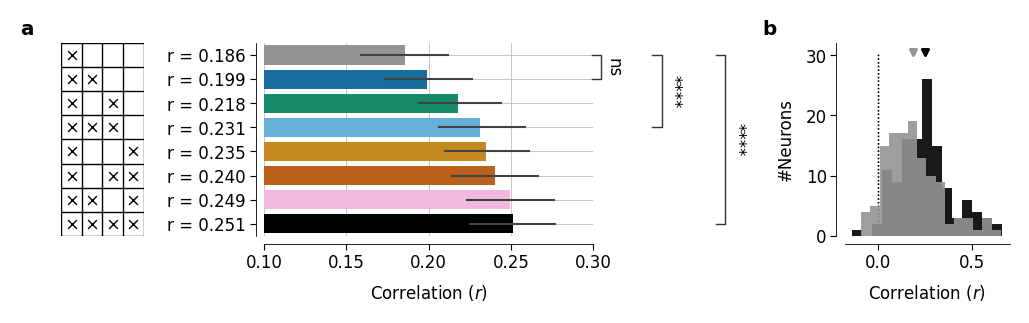

In [95]:
with plt.style.context("matplotlib_config.txt"):
    mosaic = """
    abc
    """
    fig, ax_dict = plt.subplot_mosaic(
        mosaic,
        figsize=(5, 1.5),
        dpi=200,
        constrained_layout=True,
        gridspec_kw={"width_ratios":[.25, 1, .5]},
        #sharex=True,
    )

    txt_kwargs = dict(
        color="black", fontsize="larger"
    )
    
    ax = ax_dict['a'] 
    ax.scatter(np.where(input_config==1)[1], np.where(input_config==1)[0], marker='x', color='k', s=10)
    for x_vline in np.arange(-.5, 4, 1):
        ax.axvline(x_vline, color='k')
    for h_vline in np.arange(-.5, 8, 1):
        ax.axhline(h_vline, color='k')
    ax.set_xlim([-.5, 3.5])
    ax.set_ylim([-.5, 7.5])
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_title('a', loc="left", **txt_kwargs, x=-.5, fontweight='bold')
    
    # All configs- performance
    ax = ax_dict['b'] 
    ax = sns.barplot(y='config_name', 
                     x='r_{:s}'.format(data_set), 
                     data=data, 
                     ci=95,
                     palette=np.array(config_colors)[idxs_sorted_idxs], 
                     errwidth=.75, 
                     orient='h',
                     order=np.array(config_names)[idxs_sorted_idxs],
                     zorder=1,
                     ax=ax)    
    # Pearson r on the side
    cnfgs = np.array(config_names)[idxs_sorted_idxs]
    r_configs = []
    for i, cnfg in enumerate(cnfgs):
        r_cnfg = np.mean(data[data['config_name']==cnfg]['r_{:s}'.format(data_set)].values)
        #ax.text(x=0.035, y=i+.2, s='r = {:.3f}'.format(r_cnfg), fontsize=5, color=config_colors[idxs_sorted_idxs][i])
        r_configs.append('r = {:.3f}'.format(r_cnfg))
    ax.set_yticklabels(r_configs, fontdict={'color':'white'}, alpha=0.0)
    #ax.set_yticklabels(config_names[idxs_sorted_idxs], color='white')
    # Annotations
    annotator = Annotator(ax=ax, 
                          pairs=pairs, 
                          data=data, 
                          y="config_name", 
                          x='r_{:s}'.format(data_set), 
                          order=None, 
                          orient='h',
                          short_test_name=False)
    annotator.set_custom_annotations(formatted_pvalues_plot)
    annotator.configure(loc='outside', fontsize=6, line_width=.5)
    annotator.annotate()
    # Axis
    ax.set_xlim(.1,.3)
    ax.set_xticks(np.arange(0.1, .35, 0.05))
    ax.set_axisbelow(True)
    ax.grid(lw=.25, zorder=0)
    ax.set_xlabel('Correlation ($r$)')
    ax.set_ylabel('')
    ax.set_title('', loc="left", **txt_kwargs, x=0)
    
    
    # Stim.-only model vs. Full model
    ax = ax_dict['c'] 
    configs = ['Full model', 'Stimulus only']
    for config in configs:
        r_test = data[data['config_name']==config]['r_test'].values
        color = data[data['config_name']==config]['config_color'].values[0]
        ax.hist(r_test, edgecolor='none', facecolor=color, bins=15, zorder=1, alpha=.9)
        ax.scatter(np.mean(r_test), r_test.shape[0]/4, color=color, marker='v', s=5)
        ax.vlines(x=0, ymin=0, ymax=r_test.shape[0]/4, color='k', linestyle=':', lw=.5, zorder=0)
    ax.set_title('b', loc="left", **txt_kwargs, x=-.5, fontweight='bold')
    ax.set_ylabel('#Neurons')
    ax.set_xlabel('Correlation ($r$)')
    
    sns.despine(offset=3)
    
    
    ax=ax_dict['a']
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.invert_yaxis()
    
    # Save plot
    filename_plot = './plots/Fig3/performance_all_configs+hist'
    fig.patch.set_facecolor('white')
    fig.savefig(filename_plot+'.svg', facecolor=fig.get_facecolor(), transparent=False)

### 'Stimulus only' model vs. 'Full model'

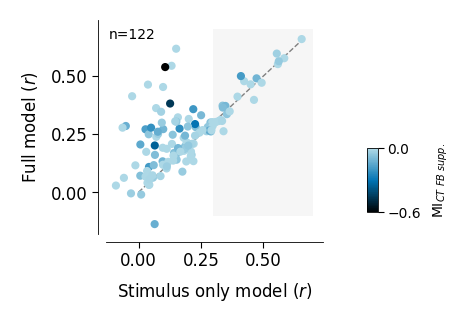

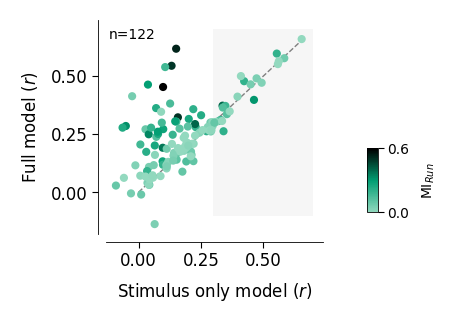

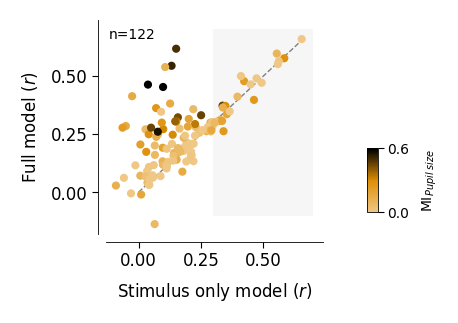

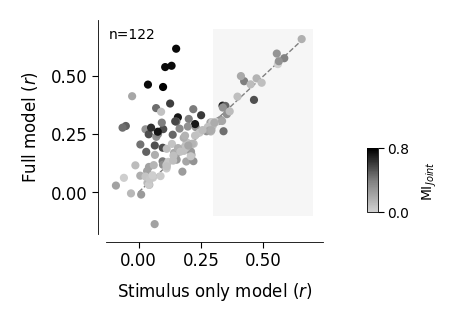

In [98]:
plt.style.use("matplotlib_config.txt")

txt_kwargs = dict(color="black", fontsize="larger")

# Assume mi_names and color_dict are defined, as well as r_test_stim_only, r_test_full_model, mi_vals, mi_labels

for i in range(4):
    fig, ax = plt.subplots(figsize=(1.6, 1.5), dpi=200, constrained_layout=True)
    
    if mi_names[i] == 'omi':
        colors_cmap = ['k', color_dict['blue'], 'lightblue']
        vmin = -.6
        vmax = 0
    elif mi_names[i] == 'rmi':
        colors_cmap = ['#93d9bfff', color_dict['green'], 'k']
        vmin = 0
        vmax = .6
    elif mi_names[i] == 'emi':
        colors_cmap = ['#efc886ff', color_dict['orange'], 'k']
        vmin = 0
        vmax = .6
    elif mi_names[i] == 'mi':
        colors_cmap = ['lightgray', 'gray', 'k']
        vmin = 0
        vmax = .8
    
    cmap = LinearSegmentedColormap.from_list(mi_names[i], colors_cmap, N=100)
    im = ax.scatter(r_test_stim_only, r_test_full_model, c=mi_vals[i], cmap=cmap, vmin=vmin, vmax=vmax, s=15, zorder=1)
    ax.plot([0, .65], [0, .65], lw=.5, color='gray', linestyle='--', zorder=0)
    ax.fill_between(x=[.3, .7], y1=-.1, y2=.7, edgecolor='none', facecolor='lightgray', alpha=.2, zorder=0)
    ax.set_xticks(np.arange(0, .7, .25))
    ax.set_yticks(np.arange(0, .6, .25))
    ax.set_xlabel('Stimulus only model ($r$)')
    ax.text(s='n={:d}'.format(r_test_stim_only.shape[0]), x=-.12, y=r_test_full_model.max(), fontsize=5)
    ax.set_title('', loc="left", **txt_kwargs, x=-.4, fontweight='bold')
    
    ax.set_ylabel('Full model ($r$)')
    
    # Colorbar
    axins = inset_axes(ax, width="5%", height="30%", loc="lower right",
                       bbox_to_anchor=(.25, .1, 1, 1), bbox_transform=ax.transAxes, borderpad=0)
    cbar = fig.colorbar(im, cax=axins, orientation='vertical', ticks=[vmin, vmax])
    cbar.ax.tick_params(labelsize=5)
    cbar.set_label(mi_labels[i], fontsize=5)
    
    sns.despine(offset=3)
    axins.spines['left'].set_visible(False)
    axins.spines['bottom'].set_visible(False)
    
    # Save each plot individually
    filename_plot = f'./plots/Fig3/scatter_{mi_names[i]}_stimonly_vs_full.svg'
    fig.patch.set_facecolor('white')
    fig.savefig(filename_plot, facecolor=fig.get_facecolor(), transparent=False)
    #plt.close(fig)  # Close the figure to free memory

# 'Modulation only' models

In [22]:
np.unique(data['config_name'].values)

array(['Full model', 'Stim.+Eye', 'Stim.+Opto', 'Stim.+Opto+Eye',
       'Stim.+Opto+Run', 'Stim.+Run', 'Stim.+Run+Eye', 'Stimulus only',
       'noStim_Eye', 'noStim_Full model', 'noStim_Opto',
       'noStim_Opto+Eye', 'noStim_Opto+Run', 'noStim_Run',
       'noStim_Run+Eye'], dtype=object)

In [99]:
data_set = 'test'

# Performance comparison all configs
sort_values = True
config_colors = data['config_color'].unique()
config_names = data['config_name'].unique()
if sort_values==True:
    config_r_means = []
    for i in range(len(config_names)):
        config_r_means.append(np.mean(data[data['config_name'] == config_names[i]]['r_mean_{:s}'.format(data_set)].values))
    idxs_sorted_idxs = np.array(config_r_means).argsort()
else:
    idxs_sorted_idxs = np.arange(config_names.shape[0])
# Create input config matrix for plotting
input_config = []
for config_name in config_names:
    input_config.append(np.hstack((np.array([True]), (data[data['config_name']==config_name].iloc[0][['config_opto', 'config_run', 'config_eye']].values))).astype(np.int))
input_config = np.vstack(input_config)
input_config = input_config[np.flip(idxs_sorted_idxs)[::-1]]    
        
# 'Stimulus only' vs. 'Full model' scatter colored by MIs
r_test_stim_only = data[data['config_name']=='Stimulus only']['r_{:s}'.format(data_set)].values
r_test_full_model = data[data['config_name']=='Full model']['r_{:s}'.format(data_set)].values
r_test_improvement = r_test_full_model-r_test_stim_only
r_test_full_noStim = data[data['config_name']=='noStim_Full model']['r_{:s}'.format(data_set)].values

omis = data[data['config_name']=='Stimulus only']['omi'].values
rmis = data[data['config_name']=='Stimulus only']['rmi'].values
emis = data[data['config_name']=='Stimulus only']['emi'].values
mis = 1-(1-abs(omis))*(1-abs(rmis))*(1-abs(emis))
mi_names = ['omi', 'rmi', 'emi', 'mi']
mi_vals = [omis, rmis, emis, mis]
mi_labels = ['MI$_{opto}$', 'MI$_{run}$', 'MI$_{eye}$', 'Non-retinal\nmodulation']

In [100]:
# Split into modulation sensitive vs. Stimulus explained neurons

thresh_improvement = .3

df_group_plt = pd.DataFrame(dict(r_test_full_model=r_test_full_model,
                                 r_test_stim_only=r_test_stim_only,
                                 r_test_full_noStim=r_test_full_noStim,
                                 improvement=r_test_improvement,
                                 group=np.hstack([['low']*40, ['medium']*40, ['high']*42]),
                                 mi=mis,
                                 omi=omis,
                                 rmi=rmis,
                                 emi=emis,
                                 #non_retinal_mod=np.hstack([['low']*40, ['medium']*40, ['high']*42]),
                                 ))
bool_improvement=np.array(['no']*r_test_full_model.shape[0])#np.zeros(r_test_full_model.shape)
bool_improvement[(df_group_plt[df_group_plt['improvement']>thresh_improvement]).index]='yes'
df_group_plt['bool_improvement']=bool_improvement

In [101]:
df_group_plt

,r_test_full_model,r_test_stim_only,r_test_full_noStim,improvement,group,mi,omi,rmi,emi,bool_improvement
0,0.331067,0.250511,0.278762,0.080556,low,0.622075,-0.091518,0.233067,0.457585,no
1,0.596130,0.553324,0.295738,0.042806,low,0.303365,-0.029472,0.199746,0.103048,no
2,0.452488,0.098257,0.450704,0.354231,low,0.868051,0.027960,0.600188,0.660479,ye
3,0.543652,0.132264,0.517195,0.411388,low,0.760586,0.002442,0.497666,0.522229,ye
4,0.477358,0.422644,0.238355,0.054714,low,0.400341,0.032290,0.199507,0.225892,no
...,...,...,...,...,...,...,...,...,...,...
117,0.267191,0.256166,0.084400,0.011025,high,0.114032,0.067908,-0.027471,-0.022636,no
118,0.062018,-0.058413,0.098059,0.120431,high,0.030500,0.013257,-0.007933,-0.009618,no
119,0.266568,0.291834,0.034289,-0.025266,high,0.189300,0.013871,0.016028,0.164505,no
120,0.174517,0.167485,0.090794,0.007032,high,0.093858,0.008913,0.004800,0.081299,no


In [102]:
pairs=[('low', 'medium'),
         ('low', 'high'),
        ]
# Stats
pvals = []
for pair in pairs:
    x = df_group_plt[df_group_plt['group']==pair[0]]['improvement'].values
    y = df_group_plt[df_group_plt['group']==pair[1]]['improvement'].values
    stats, pval = scipy.stats.mannwhitneyu(x, y, alternative='two-sided')
    pvals.append(pval)
pvals = np.array(pvals)
reject, pvals_corrected, alphacSidak, alphacBonf = statsmodels.stats.multitest.multipletests(pvals, alpha=0.05, method='bonferroni')
# Format p-values for plotting
formatted_pvalues = []
for p in pvals_corrected:
    if 1.00e-02 < p <= 5.00e-02:
        formatted_pvalues.append('*')
    elif 1.00e-03 < p <= 1.00e-02:
        formatted_pvalues.append('**')
    elif 1.00e-04 < p <= 1.00e-03:
        formatted_pvalues.append('***')
    elif p <= 1.00e-04:
        formatted_pvalues.append('****')
    else:
        formatted_pvalues.append('ns') 

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

low vs. medium: *
low vs. high: ****


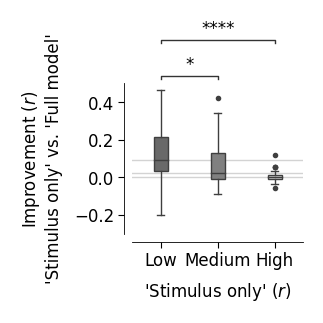

In [103]:
with plt.style.context("matplotlib_config.txt"):
    mosaic = """
    a
    """
    fig, ax_dict = plt.subplot_mosaic(
        mosaic,
        figsize=(1.5, 1.5),
        dpi=200,
        constrained_layout=True,
        #sharex=True,
    )

    txt_kwargs = dict(
        color="black", fontsize="larger"
    )

    ax = ax_dict['a'] 
    sns.boxplot(data=df_group_plt,
                y='improvement',
                x='group',
                ax=ax,
                palette=['dimgray', 'gray', 'lightgray'],
                width=.25,
                fliersize=2,
                flierprops={"marker": "."},
                zorder=5,
               )
    ax.axhline(y=np.median(df_group_plt[df_group_plt['group']=='low']['improvement'].values), linestyle='-', color='lightgray', zorder=0)
    ax.axhline(y=np.median(df_group_plt[df_group_plt['group']=='medium']['improvement'].values), linestyle='-', color='lightgray', zorder=0)
    ax.axhline(y=np.median(df_group_plt[df_group_plt['group']=='high']['improvement'].values), linestyle='-', color='lightgray', zorder=0)
    ax.set_ylim([-.3,.5])
    ax.set_xticklabels(['Low', 'Medium', 'High'])
    
    ax.set_xlabel("'Stimulus only' ($r$)")
    ax.set_ylabel("Improvement ($r$)\n'Stimulus only' vs. 'Full model'")
    
    # Annotations
    annotator = Annotator(ax=ax, 
                          pairs=pairs, 
                          data=df_group_plt, 
                          y='improvement',
                          x='group',
                          order=None, 
                          orient='v',
                          short_test_name=False)
    annotator.set_custom_annotations(formatted_pvalues)
    annotator.configure(loc='outside', fontsize=6, line_width=.5)
    annotator.annotate()    

    sns.despine(offset=3, trim=False)
    
    # Save plot
    filename_plot = './plots/Fig3/perf_gain_split_in_groups'
    fig.patch.set_facecolor('white')
    fig.savefig(filename_plot+'.svg', facecolor=fig.get_facecolor(), transparent=False)

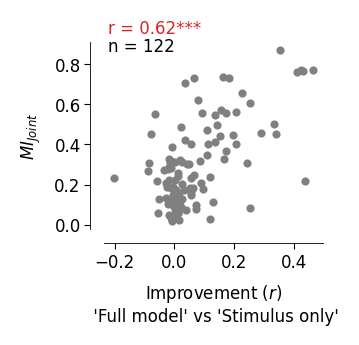

In [104]:
colors_cmap = ['lightgray', 'gray', 'k']
cmap = LinearSegmentedColormap.from_list('mi', colors_cmap, N=100)

with plt.style.context("matplotlib_config.txt"):
    mosaic = """
    a
    """
    fig, ax_dict = plt.subplot_mosaic(
        mosaic,
        figsize=(1.6, 1.5),
        dpi=200,
        constrained_layout=True,
        #sharex=True,
    )

    txt_kwargs = dict(
        color="black", fontsize="larger"
    )
    ax = ax_dict['a'] 
    im = ax.scatter(df_group_plt['improvement'].values, df_group_plt['mi'].values, color='gray', vmin=0, vmax=.8, s=15, zorder=1)#c=df_group_plt['mi'].values
    ax.set_ylabel('$MI_{Joint}$')
    ax.set_xlabel("Improvement ($r$)\n 'Full model' vs 'Stimulus only'")

    sns.despine(trim=False, offset=5)

    fig.text(s=f"r = {corrcoeff_improvement_nonretmod:.2f}{pval_star}", y=1.0, x=.3, color='tab:red')
    fig.text(s=f"n = {df_group_plt.shape[0]}", y=.94, x=.3)

    filename = 'improvement_vs_mi_wo_colors'
    fig.savefig(f"./plots/Fig3/{filename}.png", dpi=200, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)
    fig.savefig(f"./plots/Fig3/{filename}.svg", bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)

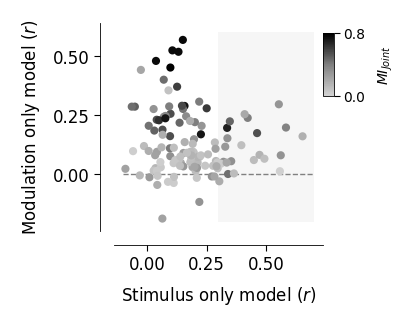

In [105]:
colors_cmap = ['lightgray', 'gray', 'k']
cmap = LinearSegmentedColormap.from_list('mi', colors_cmap, N=100)

with plt.style.context("matplotlib_config.txt"):
    mosaic = """
    a
    """
    fig, ax_dict = plt.subplot_mosaic(
        mosaic,
        figsize=(1.6, 1.5),
        dpi=200,
        constrained_layout=True,
        #sharex=True,
    )

    txt_kwargs = dict(
        color="black", fontsize="larger"
    )
    ax = ax_dict['a'] 
    ax.plot([-.1,.7], [0, 0], linestyle='--', color='gray', zorder=0)
    #ax.plot([0,0], [-.2, .6], linestyle='--', color='gray', zorder=0)
    im = ax.scatter(x=df_group_plt['r_test_stim_only'].values, 
                    y=df_group_plt['r_test_full_noStim'].values,
                    c=df_group_plt['mi'],
                    cmap=cmap,
                    vmin=0,
                    vmax=.8,
                    s=15,
                   )
    ax.set_xticks([0,.25, .5])
    ax.set_yticks([0,.25, .5])

    # Colorbar
    axins = inset_axes(ax, width="5%", height="30%", loc="lower right",
                       bbox_to_anchor=(.05, .65, 1, 1), bbox_transform=ax.transAxes, borderpad=0)
    ax.fill_between(x=[.3, .7], y1=-.2, y2=.6, edgecolor='none', facecolor='lightgray', alpha=.2, zorder=0)
    cbar = fig.colorbar(im, cax=axins, orientation='vertical', ticks=[0, .8])
    cbar.ax.tick_params(labelsize=5)
    cbar.set_label('$MI_{Joint}$', fontsize=5)

    ax.set_xlabel("Stimulus only model ($r$)")
    ax.set_ylabel('Modulation only model ($r$)')

    sns.despine(trim=False, offset=5)

    filename = 'comparison_StimOnly_vs_noStim'
    fig.savefig(f"./plots/Fig3/{filename}.png", dpi=200, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)
    fig.savefig(f"./plots/Fig3/{filename}.svg", bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)